In [1]:
# Import required packages
import numpy as np
import time 
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [33]:
print(f"This notebook uses TensorFlow Version {tf.__version__}")
print("And Python Version:")
!python --version 

This notebook uses TensorFlow Version 2.6.0
And Python Version:
Python 3.6.8 :: Anaconda, Inc.


# Results

Baseline Model Results: 

Test Set: 10.16% (can be found in the evaluation section - runs logistic regression model on test set used for models 1/2)

Model I Results: 

Noisy Train/Test Set Accuracy: 24.42%, 22.32% 
Model I Clean Labels Loss, Accuracy: [1.744310975074768, 0.5378000140190125]

Clean Image Accuracy: 53.78%

Training Time: 1013.9775972366333 Seconds 

Model II results: 

Train/Test set Accuracy: 54.93%, 53.58%

313/313 [==============================] - 9s 28ms/step - loss: 1.1817 - accuracy: 0.5901
Model II Clean Labels Loss, Accuracy: [1.1816649436950684, 0.5900999903678894]

Clean Image Accuracy: 59.01%

Train Time: 1468.9489738941193 + 587.4192531108856 = 2056.37

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


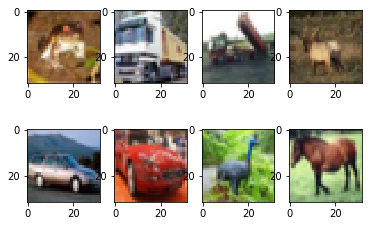

In [127]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [3]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [8]:
# [DO NOT MODIFY THISCELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kerry.cook@ibm.com/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [4]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

For model I, we use a basic CNN structure: two 2D convolutional layers, a max pooling layer, a flatten layer, a dense layer and the classficication layer. 

For the optimizer, we use Nadam and the learning rate is 0.001.

We use data augmentation in order to reduce overfitting. The data augmentation also increases the amount of data as it adds modified copies of the orginial data.

### Split Data

In [11]:
# shuffle the images and split the data into training and validation set (0.9 and 0.1)
shuff_imgs, target_vec = shuffle(imgs, noisy_labels, random_state=0)
img_train, img_test, y_train_num, y_test_num = train_test_split(shuff_imgs, target_vec, test_size=0.10, random_state=1)
# one-hot encoded vectors
y_train = np.eye(10)[y_train_num]
y_test = np.eye(10)[y_test_num]

In [68]:
def modelI():
    
    # Simple CNN with 2 convolutional layers, max pooling, flatten layer and dense layer
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # COMPILE
    opt= Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")
    
    # compile
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def train_model(model, img_train, y_train, img_test, y_test, output_fn, epochs = 10 ):
    
    # generate image data with data augmentation 
    train_gen = ImageDataGenerator(
        featurewise_center=True, # set the mean of the inputs to 0 over the dataset
        featurewise_std_normalization=True, # divide the inputs by standard deviation of the dataset
        rotation_range=20, # degree range for random rotations
        width_shift_range=0.2, # the fraction of total width
        height_shift_range=0.2, # the fraction of total height
        horizontal_flip=True) # flip the inputs horizontally randomly
    
    train_gen.fit(img_train)
    
    test_gen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    test_gen.fit(img_train)
    
    # save the weights
    file_path = f"../output/{output_fn}"
    checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # fits the model on batches with data augmentation:
    model.fit(train_gen.flow(img_train, y_train, batch_size=128),
             validation_data=train_gen.flow(img_test, y_test, batch_size=12),
             callbacks=callbacks_list,
              epochs=epochs)
    
    return model, test_gen 

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # load the model weights
    model1 = modelI() 
    model1.load_weights("../output/modelI.h5")
    
    # predict
    pred = model1.predict(data_genI.flow(image))
    pred_class = np.argmax(pred)
    
    return pred_class

Train the CNN for 6 epochs - would train for more, but only saw 2-3% gains, so reduced to 6 for the runtime reduction.

In [69]:
# record the computational time
start = time.time()
# train model 1
model = modelI()
model, data_genI = train_model(model, img_train, y_train, img_test, y_test, "modelI.h5", epochs = 6)
end = time.time() 

Epoch 1/6
352/352 [==============================] - 173s 482ms/step - loss: 2.2711 - accuracy: 0.1623 - val_loss: 2.2497 - val_accuracy: 0.1862

Epoch 00001: val_accuracy improved from -inf to 0.18620, saving model to ../output/modelI.h5
Epoch 2/6
352/352 [==============================] - 205s 581ms/step - loss: 2.2405 - accuracy: 0.1936 - val_loss: 2.2361 - val_accuracy: 0.1976

Epoch 00002: val_accuracy improved from 0.18620 to 0.19760, saving model to ../output/modelI.h5
Epoch 3/6
352/352 [==============================] - 214s 609ms/step - loss: 2.2267 - accuracy: 0.2066 - val_loss: 2.2250 - val_accuracy: 0.2108

Epoch 00003: val_accuracy improved from 0.19760 to 0.21080, saving model to ../output/modelI.h5
Epoch 4/6
352/352 [==============================] - 164s 465ms/step - loss: 2.2201 - accuracy: 0.2142 - val_loss: 2.2209 - val_accuracy: 0.2150

Epoch 00004: val_accuracy improved from 0.21080 to 0.21500, saving model to ../output/modelI.h5
Epoch 5/6
352/352 [================

In [70]:
print( f"Total Model I training time: {end-start}")

Total Model I training time: 1048.486741065979


In [71]:
train_metrics = model.evaluate(data_genI.flow(img_train, y_train))
test_metrics = model.evaluate(data_genI.flow(img_test, y_test))

print(f"Model I Training Loss, Accuracy: {train_metrics}")
print(f"Model I Testing Loss, Accuracy: {test_metrics}")

157/157 [==============================] - 4s 26ms/step - loss: 2.2040 - accuracy: 0.2362
Model I Training Loss, Accuracy: [2.1872358322143555, 0.24393333494663239]
Model I Testing Loss, Accuracy: [2.204016923904419, 0.2362000048160553]


In [72]:
# clean images and labels
img_cl = imgs[:10000]
y_cl = np.eye(10)[clean_labels]

# estimate the model accuracy using clean labels
cl_metrics = model.evaluate(data_genI.flow(img_cl, y_cl))

print(f"Model I Clean Labels Loss, Accuracy: {cl_metrics}")

313/313 [==============================] - 16s 53ms/step - loss: 1.7038 - accuracy: 0.5326
Model I Clean Labels Loss, Accuracy: [1.703821063041687, 0.5325999855995178]


### 2.3. Model II

For Model II, we train a label cleaning network that follows a similar architecture as the paper. We used a pre-trained CNN (VGG16) for the base network, and tried to match the rest of the architecture to the paper. We make the last layer of VGG16 to be trainable in order to avoid overfitting.

The label network is only trained for 6 epochs, as it is time intensive, but performance could be increased by training for more epochs. 

We then use the label cleaining network to predict new labels for the 40000 noisy images, and use the new labels along with the 10000 clean labels to retrain a new CNN that has the same architecture as Model 1. Overall accuracy increased. 

### Label Cleaning Network

In [73]:
#Get both clean and noisy labels for the first 10,000 images 
clean = np.eye(10)[clean_labels]
noisy = np.eye(10)[noisy_labels[:10000]]
clean_imgs = imgs[:10000]/255

In [74]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Lambda

#Custom loss function for comparing predicted class to clean label used for training label network 
def label_loss(y_true, y_pred):
    # L1 distance between true labels and predicted labels
    loss = K.abs(y_true - y_pred)
    loss = K.sum(loss, axis = 1)
    loss = K.sum(loss)
    return loss 
    
def label_nn():
    # input layer
    img_input = Input(shape=(32, 32, 3))
    noisy_label = Input(shape = (10))
    
    # transfer learning - using VGG16 here
    base = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(32,32,3),
        pooling='max'
    )

    # make the last layer of VGG16 trainable
    base.trainable = False
    base.get_layer('block5_conv3').trainable = True

    # use VGG16 as the base model
    img_vec = base(img_input)

    noisy_l = Dense(10)(noisy_label)
    img_vec = Dense(256)(img_vec)
    
    # concatenate noisy labels and image features
    x = Concatenate(axis=-1)([noisy_l, img_vec])
    x = Dense(256, activation = 'relu')(x)
    out = Dense(10, activation = 'softmax')(x)

    model = Model([img_input, noisy_label], out)
    # compile
    model.compile(loss=label_loss, metrics=['acc'], optimizer=RMSprop(0.001))
    
    return model

In [75]:
# record the computational time
start = time.time()
model = label_nn()
# train the label model
model.fit([clean_imgs, noisy], clean, batch_size = 128, epochs = 6)
end = time.time()

Epoch 1/6
79/79 [==============================] - 114s 1s/step - loss: 172.5874 - acc: 0.3547
Epoch 2/6
79/79 [==============================] - 98s 1s/step - loss: 137.5944 - acc: 0.4850
Epoch 3/6
79/79 [==============================] - 92s 1s/step - loss: 123.9713 - acc: 0.5374
Epoch 4/6
79/79 [==============================] - 96s 1s/step - loss: 114.7946 - acc: 0.5715
Epoch 5/6
79/79 [==============================] - 91s 1s/step - loss: 107.0405 - acc: 0.5986
Epoch 6/6
79/79 [==============================] - 94s 1s/step - loss: 102.1684 - acc: 0.6166


In [76]:
print(f"Total Label Network training Time: {end-start}")

Total Label Network training Time: 587.9895360469818


In [77]:
# save model
model.save("../output/model_labelclean.h5")

In [78]:
#Predict new labels for noisy set
noisy_imgs = imgs[10000:]/255
noisy_l = np.eye(10)[noisy_labels[10000:]]

In [79]:
# record the computational time
start = time.time()
# predict labels
new_pred = model.predict([noisy_imgs, noisy_l])
end = time.time()

In [80]:
print(f"Total Label Network prediction Time: {end-start}")

Total Label Network prediction Time: 401.26130414009094


In [82]:
#clean up label vectors
row_maxes = new_pred.argmax(axis=1)
new_labels = np.eye(10)[row_maxes]

#Create new train set from clean images and new pred labels
upd_imgs = imgs
upd_labels = np.concatenate((np.eye(10)[clean_labels], new_labels), axis=0) 

### Train Model II with clean labels and new labels from label network

In [83]:
# shuffle the images and split the data into training and validation set (0.9 and 0.1)
shuff_imgs, target_vec = shuffle(upd_imgs, upd_labels, random_state=0)
img_train, img_test, y_train, y_test = train_test_split(shuff_imgs,target_vec, test_size=0.10, random_state=42)

In [85]:
# record the computational time
start = time.time()
# train model 2
modelII = modelI()
modelII, data_genII = train_model(modelII, img_train, y_train, img_test, y_test,"modelII.h5", 6)
end = time.time()

Epoch 1/6
352/352 [==============================] - 186s 520ms/step - loss: 1.7009 - accuracy: 0.3918 - val_loss: 1.5502 - val_accuracy: 0.4450

Epoch 00001: val_accuracy improved from -inf to 0.44500, saving model to ../output/modelII.h5
Epoch 2/6
352/352 [==============================] - 155s 441ms/step - loss: 1.4713 - accuracy: 0.4802 - val_loss: 1.4227 - val_accuracy: 0.4948

Epoch 00002: val_accuracy improved from 0.44500 to 0.49480, saving model to ../output/modelII.h5
Epoch 3/6
352/352 [==============================] - 137s 389ms/step - loss: 1.3899 - accuracy: 0.5120 - val_loss: 1.3801 - val_accuracy: 0.5168

Epoch 00003: val_accuracy improved from 0.49480 to 0.51680, saving model to ../output/modelII.h5
Epoch 4/6
352/352 [==============================] - 136s 385ms/step - loss: 1.3465 - accuracy: 0.5276 - val_loss: 1.3550 - val_accuracy: 0.5246

Epoch 00004: val_accuracy improved from 0.51680 to 0.52460, saving model to ../output/modelII.h5
Epoch 5/6
352/352 [============

In [86]:
print(f"Total Model II training Time: {end-start}")

Total Model II training Time: 908.8973338603973


In [87]:
# clean images and labels
img_cl = imgs[:10000]
y_cl = np.eye(10)[clean_labels]

# estimate the model accuracy using clean labels
cl_metrics = modelII.evaluate(data_genII.flow(img_cl, y_cl))

print(f"Model II Clean Labels Loss, Accuracy: {cl_metrics}")

313/313 [==============================] - 9s 28ms/step - loss: 1.1817 - accuracy: 0.5901
Model II Clean Labels Loss, Accuracy: [1.1816649436950684, 0.5900999903678894]


In [8]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # load the model weights
    model2 = modelI() 
    model2.load_weights("../output/modelII.h5")
    
    # predict
    pred = model2.predict(data_genII.flow(image))
    pred_class = np.argmax(pred, axis = 1)
    
    return pred_class 

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [14]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



In [20]:
from sklearn.metrics import accuracy_score

def acc(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(f"Accuracy: {accuracy_score(test_labels, y_pred)}")

In [21]:
#Test Accuracy on test set used for Model 1/2
evaluation(baseline_model, y_test_num, img_test)
acc(baseline_model, y_test_num, img_test)

              precision    recall  f1-score   support

           0       0.04      0.00      0.01       494
           1       0.11      0.20      0.14       466
           2       0.04      0.00      0.00       471
           3       0.09      0.22      0.13       502
           4       0.10      0.16      0.12       511
           5       0.11      0.23      0.15       524
           6       0.09      0.05      0.07       519
           7       0.10      0.05      0.07       518
           8       0.14      0.07      0.09       473
           9       0.10      0.02      0.03       522

   micro avg       0.10      0.10      0.10      5000
   macro avg       0.09      0.10      0.08      5000
weighted avg       0.09      0.10      0.08      5000

Accuracy: 0.1016


The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

# 4. Save Label Predictions CSV

In [95]:
#Load trained Model 1/2 networks
model1 = modelI() 
model1.load_weights("../output/modelI.h5")

model2 = modelI()
model2.load_weights("../output/modelII.h5")

In [109]:
import glob
#Load test image data 
test_fp = "../test_data/images/*"
test_img_files = glob.glob(test_fp)
pred = read_csv("../output/label_prediction.csv")
files = list(pred["Index"])

test_imgs = np.empty((10000,32,32,3))
i=0
for fn in files: 
    
    f = f"../test_data/images/{fn}.png"
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2RGB)
    i+=1

In [115]:
pred

,Index,Baseline,Model I,Model II
0,test00001,6.0,6,2
1,test00002,0.0,1,8
2,test00003,8.0,9,9
3,test00004,0.0,6,2
4,test00005,4.0,4,0
...,...,...,...,...
9995,test09996,8.0,8,7
9996,test09997,5.0,6,4
9997,test09998,1.0,9,6
9998,test09999,4.0,2,2


In [ ]:
test_img_files[0]


In [101]:
import pandas as pd 

pred = pd.read_csv("../output/label_prediction.csv")


In [104]:
files = list(pred["Index"])


In [105]:
files

['test00001',
 'test00002',
 'test00003',
 'test00004',
 'test00005',
 'test00006',
 'test00007',
 'test00008',
 'test00009',
 'test00010',
 'test00011',
 'test00012',
 'test00013',
 'test00014',
 'test00015',
 'test00016',
 'test00017',
 'test00018',
 'test00019',
 'test00020',
 'test00021',
 'test00022',
 'test00023',
 'test00024',
 'test00025',
 'test00026',
 'test00027',
 'test00028',
 'test00029',
 'test00030',
 'test00031',
 'test00032',
 'test00033',
 'test00034',
 'test00035',
 'test00036',
 'test00037',
 'test00038',
 'test00039',
 'test00040',
 'test00041',
 'test00042',
 'test00043',
 'test00044',
 'test00045',
 'test00046',
 'test00047',
 'test00048',
 'test00049',
 'test00050',
 'test00051',
 'test00052',
 'test00053',
 'test00054',
 'test00055',
 'test00056',
 'test00057',
 'test00058',
 'test00059',
 'test00060',
 'test00061',
 'test00062',
 'test00063',
 'test00064',
 'test00065',
 'test00066',
 'test00067',
 'test00068',
 'test00069',
 'test00070',
 'test00071',
 'test

In [110]:
#Baseline Predictions 
baseline_pred = []
for im in test_imgs: 
    
    baseline_pred.append(baseline_model(im)[0])

In [111]:
#Model I
model1_pred = model1.predict(data_genI.flow(test_imgs))
model1_pred = np.argmax(model1_pred, axis = 1)

In [112]:
#Model II
model2_pred = model2.predict(data_genII.flow(test_imgs))
model2_pred = np.argmax(model2_pred, axis = 1)

In [113]:
#Save csv file 
import pandas as pd 

#pred = read_csv("../output/label_prediction.csv")

pred['Baseline'] = baseline_pred
pred['Model I'] = model1_pred
pred["Model II"] = model2_pred

pred.to_csv("../label_prediction.csv")

# Appendix

We ran our code on Google Colab and it works well with a RAM of 12.69 GB.

Here are the basic structures of some models we tried. We modified layers and different values of the parameters to see which structure has a higher accuracy.

In [ ]:
# Artificial neural network (ANN) 
# model=Sequential()
# model.add(Flatten(input_shape=(32,32,3)))
# model.add(Dense(256,activation='relu'))
# model.add(Dense(10,activation='softmax'))

In [ ]:
# A multilayer perceptron (MLP)
# model = Sequential()
# model.add(Dense(256, activation='relu', input_dim=3072))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(10, activation='softmax'))

In [ ]:
# Convolutionary neural network(CNN)
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(10, activation='softmax'))

In [ ]:
# Transfer Learning: VGG 16, VGG 19, ResNet50, GoogLeNet and ArcFace
# for example VGG19
# base_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])
# base_model.trainable = False
# img_input = Input(shape=(32, 32, 3))
# model = base_model(img_input)
# model = Flatten()(model)
# model = Dense(512,activation=('relu'))(model)
# out = Dense(10,activation=('softmax'))(model)
# model = Model(img_input, out)

# for example ResNet50
# base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='max')
# base_model.trainable = False
# img_input = Input(shape=(32,32,3))
# model = UpSampling2D(size=(7,7))(img_input)
# model = base_model_2(model)
# model = Flatten()(model)
# model = Dense(512, activation="relu")(model)
# out = Dense(10, activation="softmax")(model)
# model = Model(img_input, out)

# for example ArcFace

# base_model = ArcFaceModel(size=32, channels=3, num_classes=None, name='arcface_model',
                 #margin=0.5, logist_scale=64, embd_shape=512,
                 #head_type='ArcHead', backbone_type='ResNet50',
                 #w_decay=5e-4, use_pretrain=True, training=False)
# base_model.trainable = False
# img_input = Input(shape=(32, 32, 3))
# model = base_model(img_input)
# model = Flatten()(model)
# model = BatchNormalization()(model)
# model = Dense(256, activation='relu')(model)
# model = Dropout(0.3)(model)
# model = BatchNormalization()(model)
# model = Dense(128, activation='relu')(model)
# model = Dropout(0.3)(model)
# model = BatchNormalization()(model)
# model = Dense(64, activation='relu')(model)
# model = Dropout(0.3)(model)
# out = Dense(10, activation='softmax')(model)
# model = Model(img_input, out)


To reduce overfitting, we tried some layers and methods

In [ ]:
# for layers

# Modify the parameter "activity_regularizer" of the dense layer
# activity_regularizer = regularizers.l2(0.01)

# Dropout layer randomly sets input units to 0 at the given rate for each step during training
# Dropout(0.25)

# Batch Normalization layer normalizes the inputs
# BatchNormalization()

# for methods
# Early stopping stops training when a metric stops improving
# early = EarlyStopping(monitor='loss', patience=3)

# when we are using transfer learning the overfitting is about 8%
# we make some layers of the base model (such as the last fully connected layer)
# trainable in order to reduce overfitting
# base_model.get_layer('block5_conv4').trainable = True

We tried different optimizers and adjust the value of parameters

In [ ]:
# Gradient descent (with momentum) optimizer
# sgd = SGD(learning_rate=0.001,momentum=.9,nesterov=False)

# RMSprop
# rms = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)

# Adam
# adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Nadam
# nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Adadelta
# ada = Adadelta(learning_rate=0.1, rho=0.95, epsilon=1e-07)

For the learning rate of the optimizer, we tried learning rate schedulers

In [ ]:
# ExponentialDecay
# an exponential decay schedule
# lr_schedule = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.90)

# ReduceLROnPlateau
# this reduces learning rate when a metric stops improving
# lrr= ReduceLROnPlateau( monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)
# callbacks = [lrr]


After adjusting model structure, tuning the values of hyperparameters and applying different methods, model I and model II are the best of all. The accuracy of ANN, MLP and CNN with other structures is about low 20s. The accuracy of transfer learning is about 35s but takes almost ten minutes per epoch.